In [207]:
%load_ext autoreload
%autoreload 1


%reset -f

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.style.use("ggplot")
sns.set_style("whitegrid")


import pickle
from sklearn.externals import joblib

import settings

import helpers as hlp
%aimport helpers
from data.preprocessing import load_file,save_file,filter_by_season,get_scaled_series,display_df
%aimport data.preprocessing
from features import tools
%aimport features.tools
from models.metrics import getMSE,getMAE,getMAPE,getsMAPE,getMASE

from visualization import cluster_analysis as ca

%matplotlib inline

row_headers = settings.row_headers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
p1cc = load_file("p1cc",index="Product")
s = "Autumn"
v = 1
clustering_model = "nb_p2_clusters_%s"%(s)
# clustering_model = "p2_clusters_Autumn_v99"

#Load files
raw_df = load_file("p2_raw").set_index(row_headers)
series_df =load_file("p2_series",type_="P",version = 1).set_index(row_headers)
clean_df = load_file("p2_clean",type_="P",version = 1).set_index(row_headers)

#Filter and normalize
sclean_df = filter_by_season(clean_df,s)
zclean_df,_ =  get_scaled_series(sclean_df)

#clustering result
cluster_df = load_file(clustering_model,index=row_headers,type_="M",version = v)

features_df = load_file("clf_features",type_="P",index = "Product")
features_df.Ldate = features_df.Ldate.apply(lambda x:str(x))
encoded_df = tools.encode(features_df,non_categorical = ["Tprice"]+["s1","s2","s3","s4","s5"])

# Cluster Profiles and centroids

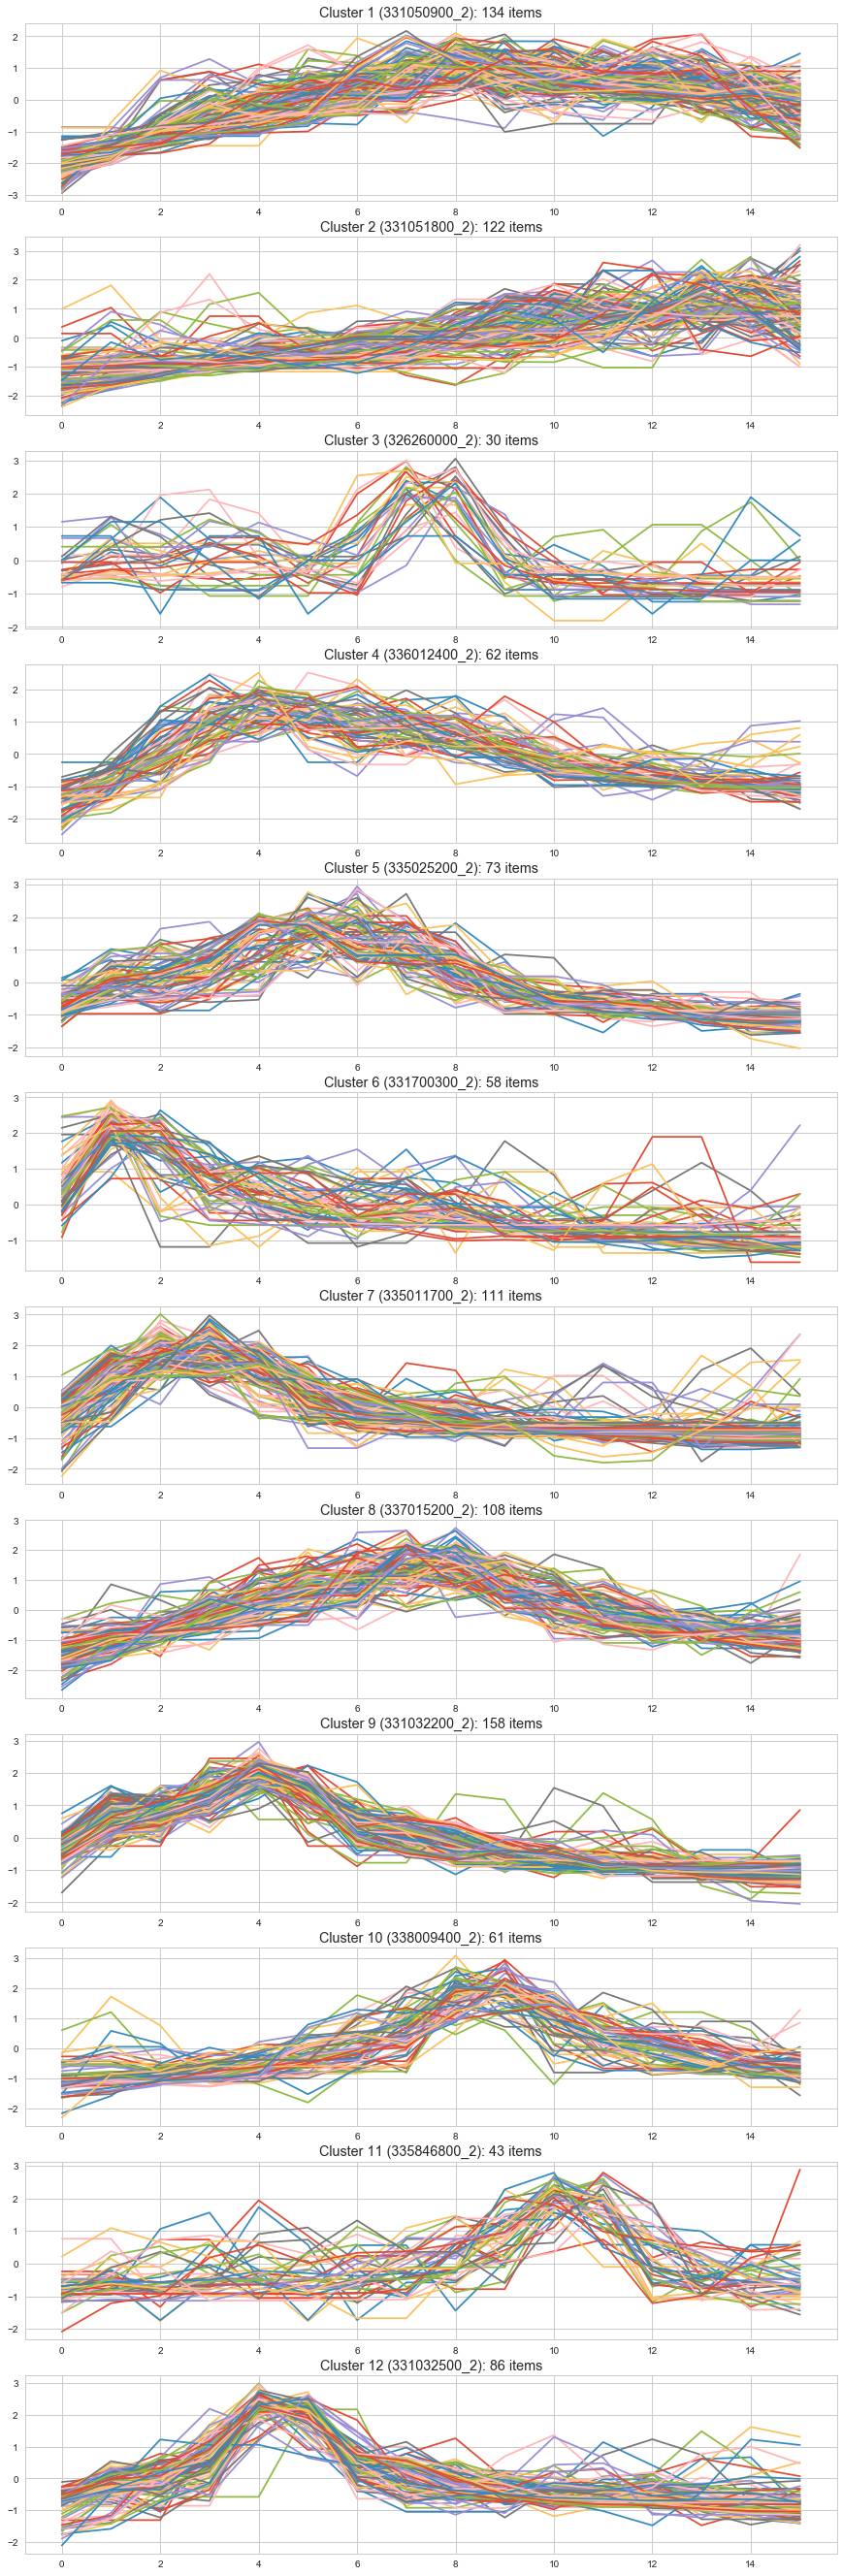

In [211]:
ca.cluster_plot(zclean_df.join(cluster_df, how="inner"))

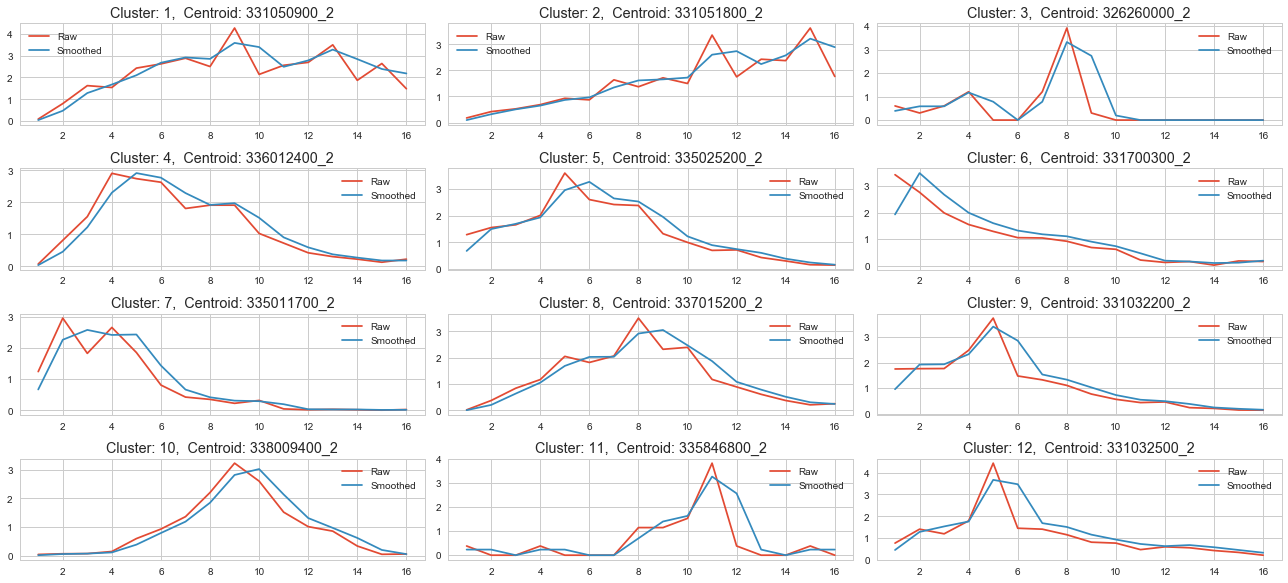

In [212]:
ca.centroid_grid_plot(raw_df,clean_df,cluster_df)

In [213]:
X_train = joblib.load(settings.models_path+'Xtrain_demo.pkl')
X_test = joblib.load(settings.models_path+'X_test_demo.pkl')
y_train = joblib.load(settings.models_path+'y_train_demo.pkl')
y_test = joblib.load(settings.models_path+'y_test_demo.pkl')
classifier = joblib.load(settings.models_path+'classifier_demo.pkl')

y_pred_proba=classifier.model.predict_proba(X_test)

In [214]:
argsorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
nguess = argsorted[:,0:4]+1

series_df = raw_df.copy()
predictions = nguess
n_pred = predictions.shape[1]
pred_df = pd.DataFrame(predictions,columns=["PC%d"%g for g in np.arange(n_pred)+1 ],index=X_test.index)

cluster_centroid = cluster_df[["Cluster","Centroid"]].drop_duplicates().set_index(["Cluster"]).to_dict()["Centroid"]
centroid_cluster = {v: k for k, v in cluster_centroid.items()}


for i in np.arange(n_pred)+1:
    pred_df["PR%d"%i] = pred_df["PC%d"%i].apply(lambda x: cluster_centroid[x])
    
product_centroid = X_test.join(cluster_df)[["Cluster","Centroid"]]
full_series = pred_df.join(product_centroid.join(series_df.astype(np.float64), how="inner"),how="inner")
display_df(full_series.sort_index())

(210, 26)


,PC1,PC2,PC3,PC4,PR1,PR2,PR3,PR4,Cluster,Centroid,...,7,8,9,10,11,12,13,14,15,16
Product,,,,,,,,,,,,,,,,,,,,,
31C002201_2,7,5,9,4,335011700_2,335025200_2,331032200_2,336012400_2,4,336012400_2,...,214.0,158.0,124.0,127.0,84.0,35.0,23.0,29.0,11.0,6.0
31C002500_2,7,6,9,5,335011700_2,331700300_2,331032200_2,335025200_2,9,331032200_2,...,103.0,23.0,43.0,7.0,8.0,37.0,4.0,12.0,5.0,5.0
31C999901_2,7,6,2,8,335011700_2,331700300_2,331051800_2,337015200_2,6,331700300_2,...,38.0,20.0,23.0,7.0,8.0,51.0,26.0,57.0,38.0,84.0
31C999903_2,6,7,9,10,331700300_2,335011700_2,331032200_2,338009400_2,6,331700300_2,...,13.0,7.0,10.0,2.0,3.0,12.0,8.0,20.0,11.0,62.0
31C999904_2,10,4,8,1,338009400_2,336012400_2,337015200_2,331050900_2,10,338009400_2,...,3181.0,5041.0,6729.0,8027.0,3381.0,4582.0,2675.0,2281.0,1501.0,943.0


In [215]:
p_series = full_series.copy()
N = p_series.shape[0]
notin = p_series[ (p_series.Cluster!=p_series.PC1) & (p_series.Cluster!=p_series.PC2) &(p_series.Cluster!=p_series.PC3)  &(p_series.Cluster!=p_series.PC4)].shape[0]

print("%.2f Not in Top 4 guesses"%(notin/N*100))

offset = (n_pred * 2) + 2
guess = 1

s_true = np.zeros((series_df.shape))
s_pred = np.zeros((series_df.shape))
MSE = np.zeros((p_series.shape[0],1))
MAE =  np.zeros((p_series.shape[0],1))
MAPE = np.zeros((p_series.shape[0],1))
sMAPE = np.zeros((p_series.shape[0],1))
i = 0
for index,values in p_series.iterrows():
    centroid = values["PR%d"%guess]
    cluster = values["Centroid"]
    
    #Getting the series raw, centroid of actual cluster, centroid of predicted cluster
    series = (values[offset:]).astype(np.float64)#/values[offset:].std()).astype(np.float64)
    c_series = (series_df.loc[cluster]).astype(np.float64)#/series_df.loc[cluster].std()).astype(np.float64)
    predicted_series = (series_df.loc[centroid]).astype(np.float64)#/series_df.loc[centroid].std()).astype(np.float64)
    
    s_true[i] = series
    s_pred[i] = c_series
    
    n = len(series)
    mse = getMSE(series,predicted_series)
    mae = getMAE(series,predicted_series)
    mape = getMAPE(series+1,predicted_series+1)
    smape = getsMAPE(series,predicted_series)
    
    MSE[i] = mse
    MAE[i] = mae
    MAPE[i] = mape
    sMAPE[i] = smape
    i+=1

13.81 Not in Top 4 guesses


In [216]:
sales = p_series.values[:,offset:].astype(np.float64)
p_series["RMSE"] = np.sqrt(MSE)
p_series["MAE"] = MAE
p_series["MAPE"] = MAPE
results = pd.DataFrame(index = p_series.index)

p_series.fillna(0, inplace = True)

results["Mean"] = sales.mean(axis=1)
results["Std"]  = sales.std(axis=1)
results["Range"] = sales.max(axis=1) - sales.min(axis=1)
results["RMSE"] = np.sqrt(MSE)
results["MAE"] = MAE
results["MAPE"] = MAPE

results.nsmallest(210,"MAE").head(25)

results.MAPE.describe()
np.median(results.MAPE)

3.2164385331561829

# Classification: Cluster prediction
Given a new product, we try to predict the cluster in which it lays the best

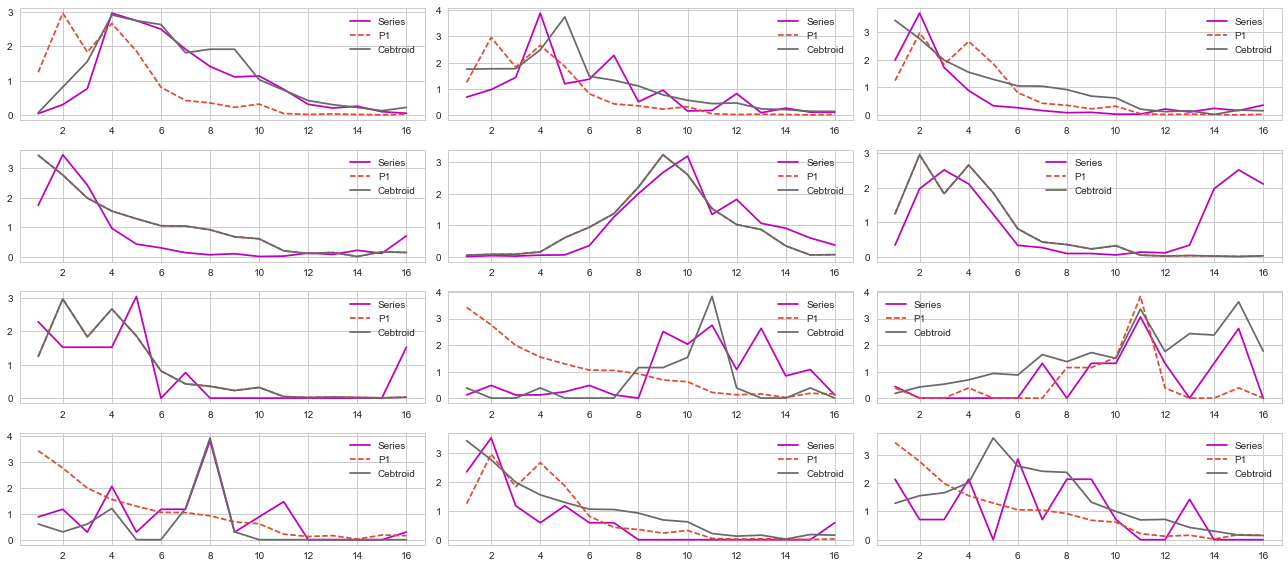

In [217]:
plt.figure(figsize=(18,2 * 4))
i=1;

disp = p_series.iloc[:12,:-3]#.loc[bad.index[:12]]

for index,values in disp.iterrows():
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    series = values[offset:]/values[offset:].std()
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    predicted_series = series_df.loc[guess1]/series_df.loc[guess1].std()
    
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    plt.subplot(4,3,i)
    plt.plot(series,label="Series",c='m')
    plt.plot(predicted_series,label="P1",ls='--')
    plt.plot(c_series,label="Cebtroid",c='dimgrey')
#     plt.plot(p2,label="P2",ls='--')
#     plt.plot(p3,label="P3",ls='--')
#     bplt.plot(p4,label="P4",ls='--')
    
    #show the centroid as well
    
    
    plt.legend(loc=0)
    
    i+=1
    

plt.tight_layout()
plt.show()

# Predict Quantities

In [218]:
predictor = joblib.load(settings.models_path+'regressor_std_log.pkl')

disp = p_series.iloc[:,:-3]

FMSE = np.zeros((disp.shape[0],1))
FMAE =  np.zeros((disp.shape[0],1))
FMAPE = np.zeros((disp.shape[0],1))
FsMAPE = np.zeros((disp.shape[0],1))
FMASE =  np.zeros((disp.shape[0],1))
i=0
for index,values in disp.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = np.exp(prediction)
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    #multiply by the std
    p1 *= pstd 
    p2 *= pstd 
    p3 *= pstd
    p4 *= pstd
    c_series *= pstd
    
    
    mse = getMSE(series,p1)
    mae = getMAE(series,p1)
    mape = getMAPE(series+1,p1+1)
    mase = getMASE(series,series,p1)

    FMSE[i] = mse
    FMAE[i] = mae
    FMAPE[i] = mape
    FMASE[i] = mase
    
    try:
        smape = getsMAPE(series,p1)
        FsMAPE[i]=smape
    except:
        FsMAPE[i]=0
    i+=1




(8, 7)


,Mean,Std,Range,RMSE,MAE,MAPE,MASE
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,343.826997,305.594226,1126.145775,267.354828,202.927839,1.084276,1.612711
std,792.285712,609.203954,2227.262695,719.819579,529.862976,0.907024,1.386577
min,0.729495,0.870841,3.000000,0.757752,0.558915,0.009635,0.029531
25%,23.792349,44.500844,178.372422,4.968293,3.672515,0.537618,0.833771


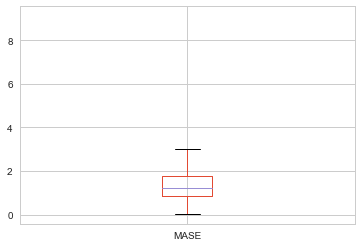

In [219]:
sales = p_series.values[:,offset:].astype(np.float64)
disp["RMSE"] = np.sqrt(FMSE)
disp["MAE"] = FMAE
disp["MAPE"] = FMAPE
disp["MASE"] = FMASE

fresults = pd.DataFrame(index = p_series.index)
p_series.fillna(0, inplace = True)

fresults["Mean"] = sales.mean(axis=1)
fresults["Std"]  = sales.std(axis=1)
fresults["Range"] = sales.max(axis=1) - sales.min(axis=1)
fresults["RMSE"] = np.sqrt(FMSE)
fresults["MAE"] = FMAE
fresults["MAPE"] = FMAPE
fresults["MASE"] = FMASE


fresults.nsmallest(210,"MAE").head()

display_df(fresults.describe())
# fresults[fresults.MAE<500].MAE.plot(kind="box")

# nosmall = fresults.MAE<fresults.Std
# fresults[nosmall].MAPE.plot(kind="box")

fresults.MASE.plot(kind="box")
# fresults.MASE.plot(kind="hist")

### Displaying plots

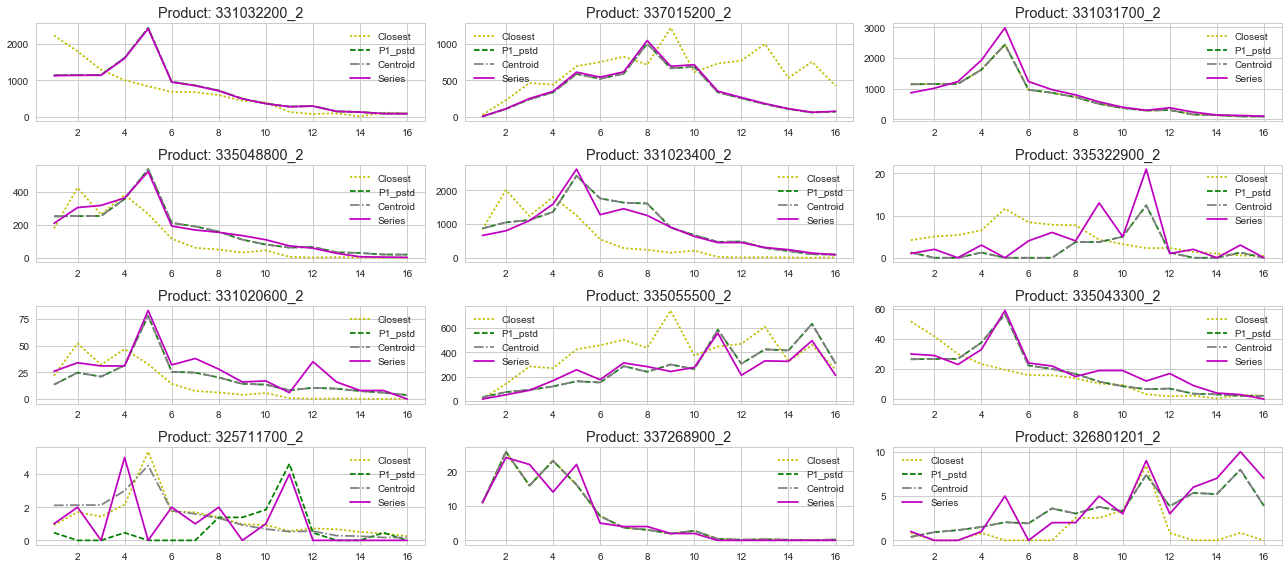

In [224]:
from sklearn.neighbors import NearestNeighbors

slices = 0 * 12
display_result = disp.nsmallest(disp.shape[0],"MASE").iloc[slices:slices+12,:-4]

# slices = -1 * 12
# display_result = disp.nsmallest(disp.shape[0],"MASE").iloc[slices:,:-4]

# display_df(disp.loc[display_result.index])
plt.figure(figsize=(18,8))

n_points = 3
i=1;
for index,values in display_result.iterrows():
    
    #Get the curves
    guess1 = values["PR1"]
    guess2 = values["PR2"]
    guess3 = values["PR3"]
    guess4 = values["PR4"]
    cluster = values["Centroid"]
    
    #Get the std from the built predictor
    encoded = encoded_df.loc[[index]]
    prediction = predictor.predict(encoded)
    pstd = np.exp(prediction)
    
    #actual series
    series = values[offset:]
    c_series = series_df.loc[cluster]/series_df.loc[cluster].std()
    
    #curve of each prediction
    p1 = series_df.loc[guess1]/series_df.loc[guess1].std()
    p2 = series_df.loc[guess2]/series_df.loc[guess2].std()
    p3 = series_df.loc[guess3]/series_df.loc[guess3].std()
    p4 = series_df.loc[guess4]/series_df.loc[guess4].std()
    
    
    plt.subplot(4,3,i)
    
    first_std = series[:n_points].std()
    if (first_std)==0: first_std = 1
    first_points = series[:n_points]/first_std
    
    p_array = pd.DataFrame([p1,p2,p3,p4],columns = series_df.columns)
    
    plt.title("Product: %s" % (index))
        
    #Adjusted
    knn = NearestNeighbors(n_neighbors=1, metric="euclidean")
    knn.fit(p_array.iloc[:,:n_points])  
    closest = knn.kneighbors([first_points], 1, return_distance=False)[0][0]
    
#     cstd = (series[:n_points]/p_array.iloc[closest,:n_points]).median()
    
    #multiply by the caluclated std
#     p1c = p1 * cstd 
    p1p = p1 * pstd[0] 
    c_series *=  pstd[0]
    
    
#     plt.plot(p1c,label="P1_cstd",ls='--',c='b')
    plt.plot(p_array.iloc[closest]*pstd,label="Closest",c='y',ls=':')
    plt.plot(p1p,label="P1_pstd",ls='--',c='g')
    
    
    plt.plot(c_series,label="Centroid",c='grey',ls='-.')
    plt.plot(series,label="Series",c='m')

    plt.legend(loc=0)
    i+=1

plt.tight_layout()
plt.show()